In [ ]:
# Core imports
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure we are in the project root (one level above notebooks/)
cwd = os.getcwd()
if cwd.endswith("notebooks"):
    os.chdir("..")
    cwd = os.getcwd()

project_root = cwd
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import load_indices
from src.features import compute_features
from src.crisis_windows import label_crisis_periods

# Load raw data, compute features, label crises
raw_data = load_indices()
data_with_features = compute_features(raw_data)
labelled_data = label_crisis_periods(data_with_features)

print("Loaded indices:", list(labelled_data.keys()))
print("Current working dir:", os.getcwd())


Loading SP500 from data/raw/SP500.csv...
Loading NASDAQ from data/raw/NASDAQ.csv...
Loading STOXX50 from data/raw/STOXX50.csv...
Loading FTSE100 from data/raw/FTSE100.csv...
[OK] SP500: features computed (null log_returns=3)
[OK] NASDAQ: features computed (null log_returns=3)
[OK] STOXX50: features computed (null log_returns=3)
[OK] FTSE100: features computed (null log_returns=3)
[OK] SP500: crisis labels assigned (crisis days=1478, pre-crisis days=503)
[OK] NASDAQ: crisis labels assigned (crisis days=1478, pre-crisis days=503)
[OK] STOXX50: crisis labels assigned (crisis days=804, pre-crisis days=372)
[OK] FTSE100: crisis labels assigned (crisis days=1487, pre-crisis days=502)
Loaded indices: ['SP500', 'NASDAQ', 'STOXX50', 'FTSE100']
Current working dir: /files/Final-Project-Luigi-Dimonte


/files/Final-Project-Luigi-Dimonte/src/data_loader.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce")
/files/Final-Project-Luigi-Dimonte/src/data_loader.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce")
/files/Final-Project-Luigi-Dimonte/src/data_loader.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce")
/files/Final-Project-Luigi-Dimonte/src/data_loader.py:50: UserWarning: Could not infer format, so each elemen

In [ ]:
# Combine all indices into one long DataFrame with an 'index_name' column

frames = []
for name, df in labelled_data.items():
    tmp = df.copy()
    tmp["index_name"] = name
    frames.append(tmp)

panel = pd.concat(frames)
panel.head()


,Close,High,Low,Open,Volume,log_return,vol_30d,peak,drawdown,regime,crisis_name,is_crisis,is_pre_crisis,is_high_risk,index_name
Price,,,,,,,,,,,,,,,
1985-01-02,165.369995,167.1999969482422,165.19000244140625,167.1999969482422,67820000,NaN,NaN,165.369995,0.000000,normal,None,0,0,0,SP500
1985-01-03,164.570007,166.11000061035156,164.3800048828125,165.3699951171875,88880000,-0.004849,NaN,165.369995,-0.004838,normal,None,0,0,0,SP500
1985-01-04,163.679993,164.5500030517578,163.36000061035156,164.5500030517578,77480000,-0.005423,NaN,165.369995,-0.010220,normal,None,0,0,0,SP500
1985-01-07,164.240005,164.7100067138672,163.67999267578125,163.67999267578125,86190000,0.003416,NaN,165.369995,-0.006833,normal,None,0,0,0,SP500
1985-01-08,163.990005,164.58999633789062,163.91000366210938,164.24000549316406,92110000,-0.001523,NaN,165.369995,-0.008345,normal,None,0,0,0,SP500


In [7]:
# Count number of days by index and regime

days_by_regime = (
    panel
    .groupby(["index_name", "regime"])
    .size()
    .unstack("regime")
    .fillna(0)
    .astype(int)
)

days_by_regime


regime,crisis,normal,post_crisis,pre_crisis
index_name,,,,
FTSE100,1487,7614,502,502
NASDAQ,1478,7599,502,503
SP500,1478,7599,502,503
STOXX50,804,2903,375,372


In [15]:
# Mean and std of log returns by index and regime

returns_stats = (
    panel
    .groupby(["index_name", "regime"])["log_return"]
    .agg(["mean", "std"])
    .reset_index()
)

returns_stats


,index_name,regime,mean,std
0,FTSE100,crisis,-0.000786,0.016983
1,FTSE100,normal,0.000364,0.009022
2,FTSE100,post_crisis,0.000469,0.013084
3,FTSE100,pre_crisis,0.000132,0.010222
4,NASDAQ,crisis,-0.001243,0.024576
5,NASDAQ,normal,0.000597,0.010827
6,NASDAQ,post_crisis,0.001492,0.014261
7,NASDAQ,pre_crisis,0.001824,0.012229
8,SP500,crisis,-0.000781,0.018809
9,SP500,normal,0.000506,0.009499


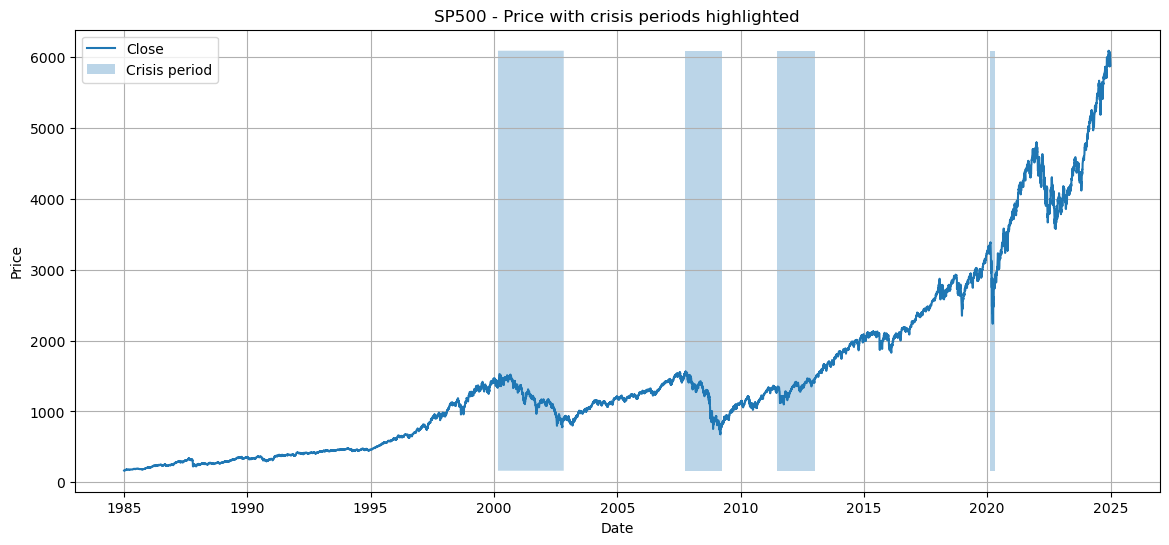

In [13]:
# Plot price for one index with crisis periods highlighted

index_to_plot = "SP500"   # puoi cambiare con 'NASDAQ', 'FTSE100', 'STOXX50'

df = labelled_data[index_to_plot]

plt.figure(figsize=(14, 6))

# Base price line
plt.plot(df.index, df["Close"], label="Close")

# Shade crisis periods
crisis_mask = df["regime"] == "crisis"
plt.fill_between(
    df.index,
    df["Close"].min(),
    df["Close"].max(),
    where=crisis_mask,
    alpha=0.3,
    label="Crisis period"
)

plt.title(f"{index_to_plot} - Price with crisis periods highlighted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


regime        crisis    normal  post_crisis  pre_crisis
index_name                                             
FTSE100     0.014749  0.008309     0.013422    0.009654
NASDAQ      0.021892  0.009713     0.014884    0.011148
SP500       0.015851  0.008494     0.013152    0.008937
STOXX50     0.019072  0.010707     0.014677    0.009643


<Figure size 1000x600 with 0 Axes>

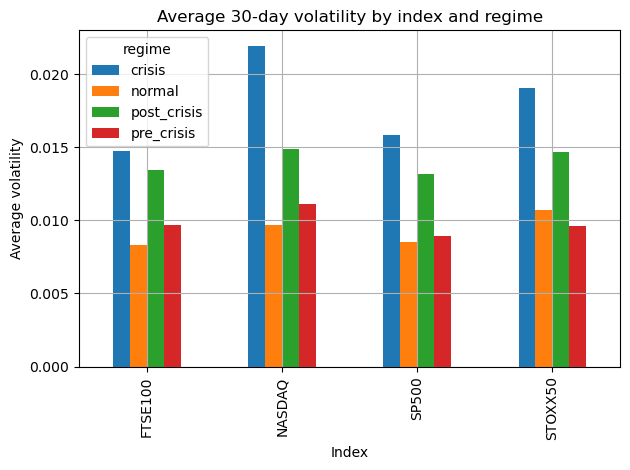

In [ ]:
# Bar plot: average volatility by index and regime

# Recompute vol_stats here to be 100% sure it exists
vol_stats = (
    panel
    .groupby(["index_name", "regime"])["vol_30d"]
    .agg(["mean", "std"])
    .reset_index()
)

# Pivot table: rows = index, columns = regime, value = mean vol
pivot_vol = vol_stats.pivot(index="index_name", columns="regime", values="mean")

print(pivot_vol)  # quick check

plt.figure(figsize=(10, 6))
pivot_vol.plot(kind="bar")
plt.title("Average 30-day volatility by index and regime")
plt.xlabel("Index")
plt.ylabel("Average volatility")
plt.grid(True)
plt.tight_layout()
plt.show()


Interpretation – Volatility by regime
Across all indices, average 30-day volatility is substantially higher during crisis and pre-crisis periods compared to normal times.
NASDAQ shows the strongest increase, suggesting that tech-heavy markets react more violently to systemic stress.
Post-crisis volatility tends to remain above normal levels, consistent with a slow normalisation process after large shocks.

regime        crisis    normal  post_crisis  pre_crisis
index_name                                             
FTSE100    -0.000786  0.000364     0.000469    0.000132
NASDAQ     -0.001243  0.000597     0.001492    0.001824
SP500      -0.000781  0.000506     0.001097    0.000654
STOXX50    -0.001370  0.000245     0.000875    0.000583


<Figure size 1000x600 with 0 Axes>

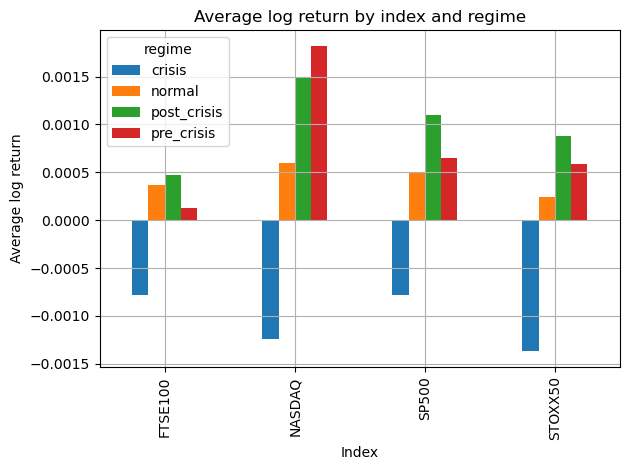

In [ ]:
# Mean returns by index and regime (normal vs crisis)

# Recompute returns_stats to ensure the variable exists
returns_stats = (
    panel
    .groupby(["index_name", "regime"])["log_return"]
    .agg(["mean", "std"])
    .reset_index()
)

# Pivot table: rows = index_name, columns = regime, values = mean returns
pivot_returns = returns_stats.pivot(index="index_name", columns="regime", values="mean")

print(pivot_returns)   # quick check

plt.figure(figsize=(10, 6))
pivot_returns.plot(kind="bar")
plt.title("Average log return by index and regime")
plt.xlabel("Index")
plt.ylabel("Average log return")
plt.grid(True)
plt.tight_layout()
plt.show()


Interpretation – Returns by regime
Mean daily log returns are close to zero or slightly positive during normal periods, but become clearly negative during crises for all indices.
Pre-crisis returns are already lower than normal, especially for FTSE100, which may indicate some degree of “early deterioration” before the shock becomes official.
Post-crisis returns often turn positive, reflecting partial recovery phases.